## Import & Install PySpark

In [3]:
!pip install pyspark

In [4]:
# importing libraries
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import *

import pandas as pd  
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import os 

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from math import sqrt

%matplotlib inline

sc = pyspark.SparkContext('local[*]')

### pyspark.sql.SparkSession Main entry point for DataFrame and SQL functionality.
#### The entry point to programming Spark with the Dataset and DataFrame API.

A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over tables, cache tables, and read parquet files. To create a SparkSession, use the following builder pattern:
[Source](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SparkSession)

In [5]:
spark = SparkSession.builder.master("local").appName("cs5590").config("spark.some.config.option", "some-value").getOrCreate()

# Data frames of Energy and Weather data

### Read data from github, into pandas, convert to dataframe.

In [6]:
url = 'https://raw.githubusercontent.com/BillYerkes/CSEE5590_GroupProject/main/Data/energy_dataset.csv'
pandaDF_Energy = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/BillYerkes/CSEE5590_GroupProject/main/Data/weather_features.csv'
pandaDF_Weather = pd.read_csv(url)

In [7]:
EnergyDF = spark.createDataFrame(pandaDF_Energy)
EnergyDF.printSchema()
EnergyDF.show()
EnergyDF.count()


root
 |-- time: string (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil coal-derived gas: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation fossil oil shale: double (nullable = true)
 |-- generation fossil peat: double (nullable = true)
 |-- generation geothermal: double (nullable = true)
 |-- generation hydro pumped storage aggregated: double (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation marine: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- gener

35064

In [8]:
WeatherDF = spark.createDataFrame(pandaDF_Weather)
WeatherDF.printSchema()
WeatherDF.show()
WeatherDF.count()


root
 |-- dt_iso: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: long (nullable = true)
 |-- wind_deg: long (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- weather_id: long (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- weather_icon: string (nullable = true)

+--------------------+---------+------------------+------------------+------------------+--------+--------+----------+--------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|              dt_iso|city_name|              temp|          temp_min|          temp_max|

178396

###Function so we can add offset back to time stamp

We are saving it as a string, we will later convert it back to a timestamp

In [9]:
from datetime import datetime, timedelta
format = "%Y-%m-%d %H:%M:%S"

def addTimeOffset(v_date, v_hour, v_minute):
  new_datetime = timedelta(minutes = int(v_minute), hours = int(v_hour))
  return_dt = v_date + new_datetime
  date_string = return_dt.strftime(format)
  return date_string
udfaddTimeOffset = f.udf(addTimeOffset, StringType())



## Converting the string to a timestamp
## also pulling out the hours and minute offset

In [10]:
EnergyDF = EnergyDF.withColumn('dtTimeStamp', to_timestamp(f.substring('time', 1,19), 'yyyy-MM-dd HH:mm:ss')) \
                   .withColumn('dtHourOffset', f.substring('time', 21,2)) \
                   .withColumn('dtMinuteOffset', f.substring('time', 24,2))

WeatherDF = WeatherDF.withColumn('dtTimeStamp', to_timestamp(f.substring('dt_iso', 1,19), 'yyyy-MM-dd HH:mm:ss')) \
                     .withColumn('dtHourOffset', f.substring('dt_iso', 21,2)) \
                     .withColumn('dtMinuteOffset', f.substring('dt_iso', 24,2))

                

### Removing rows which do not have a value for total load actual

In [11]:
EnergyDF = EnergyDF.na.drop(subset=['total load actual'])


### Add new timestamp to DF with offset added to them

In [12]:
EnergyDF = EnergyDF.withColumn("interval", udfaddTimeOffset("dtTimeStamp","dtHourOffset","dtMinuteOffset"))
EnergyDF = EnergyDF.withColumn('dtTimeStampUpdated', to_timestamp("interval", 'yyyy-MM-dd HH:mm:ss'))

WeatherDF = WeatherDF.withColumn("interval", udfaddTimeOffset("dtTimeStamp","dtHourOffset","dtMinuteOffset"))
WeatherDF = WeatherDF.withColumn('dtTimeStampUpdated', to_timestamp("interval", 'yyyy-MM-dd HH:mm:ss'))

EnergyDF.select('dtTimeStamp','dtTimeStampUpdated').show()
WeatherDF.select('dtTimeStamp','dtTimeStampUpdated').show()

+-------------------+-------------------+
|        dtTimeStamp| dtTimeStampUpdated|
+-------------------+-------------------+
|2015-01-01 00:00:00|2015-01-01 01:00:00|
|2015-01-01 01:00:00|2015-01-01 02:00:00|
|2015-01-01 02:00:00|2015-01-01 03:00:00|
|2015-01-01 03:00:00|2015-01-01 04:00:00|
|2015-01-01 04:00:00|2015-01-01 05:00:00|
|2015-01-01 05:00:00|2015-01-01 06:00:00|
|2015-01-01 06:00:00|2015-01-01 07:00:00|
|2015-01-01 07:00:00|2015-01-01 08:00:00|
|2015-01-01 08:00:00|2015-01-01 09:00:00|
|2015-01-01 09:00:00|2015-01-01 10:00:00|
|2015-01-01 10:00:00|2015-01-01 11:00:00|
|2015-01-01 11:00:00|2015-01-01 12:00:00|
|2015-01-01 12:00:00|2015-01-01 13:00:00|
|2015-01-01 13:00:00|2015-01-01 14:00:00|
|2015-01-01 14:00:00|2015-01-01 15:00:00|
|2015-01-01 15:00:00|2015-01-01 16:00:00|
|2015-01-01 16:00:00|2015-01-01 17:00:00|
|2015-01-01 17:00:00|2015-01-01 18:00:00|
|2015-01-01 18:00:00|2015-01-01 19:00:00|
|2015-01-01 19:00:00|2015-01-01 20:00:00|
+-------------------+-------------

#Query to get count for each City

Seeing how the data is distributed between the five cities.

Most of the data investication was done in MapReduce and Hive.

This was the first query done in Spark.

In [13]:
city = WeatherDF.select('city_name')

city.printSchema()
city.count()

city.groupBy("city_name").count().show()

root
 |-- city_name: string (nullable = true)

+----------+-----+
| city_name|count|
+----------+-----+
|    Madrid|36267|
|   Seville|35557|
| Barcelona|35476|
|    Bilbao|35951|
|  Valencia|35145|
+----------+-----+



### Inner Join between the weather and energy dataframes

In [14]:
WeatherPartialDF = WeatherDF.groupBy('dtTimeStampUpdated').agg(f.avg("temp").alias("Temp_avg"), \
                                                               f.avg("pressure").alias("Pressure_avg"),\
                                                               f.avg("humidity").alias("humidity_avg") )

WeatherTempDF = WeatherDF.groupBy('dtTimeStampUpdated').agg(f.avg("temp").alias("Temp_avg"))
EnergyDFTotalLoad = EnergyDF.select('dtTimeStampUpdated','total load actual')

WeatherEnergyDF = WeatherTempDF.join(EnergyDF, on=['dtTimeStampUpdated'], how='inner')
EnergyWeatherDF = EnergyDFTotalLoad.join(WeatherPartialDF, on=['dtTimeStampUpdated'], how='inner')

PandasWeatherEnergyDF = WeatherEnergyDF.toPandas()
PandasEnergyWeatherDF = EnergyWeatherDF.orderBy("dtTimeStampUpdated").toPandas()

## Data for perfoming linear regression
linearReg_X = PandasWeatherEnergyDF[['Temp_avg']]
linearReg_y = PandasWeatherEnergyDF[['total load actual']]


Perform a Linear Regression

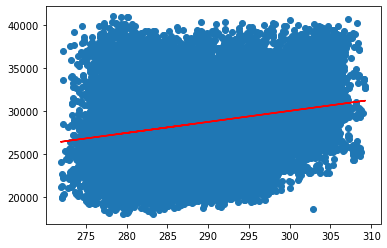

In [15]:
body_reg = linear_model.LinearRegression()
body_reg.fit(linearReg_X,linearReg_y)
# parameters
m =body_reg.coef_
c =body_reg.intercept_
plt.scatter(linearReg_X,linearReg_y)
plt.plot(linearReg_X,body_reg.predict(linearReg_X),color='Red')

## This Code was taken from Kagel

### It shows how the columns are related to each other.


In [16]:
#https://www.kaggle.com/ravikannan/starter-hourly-energy-demand-2a0c157d-2
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

## Relationship for the Energy Weather Data

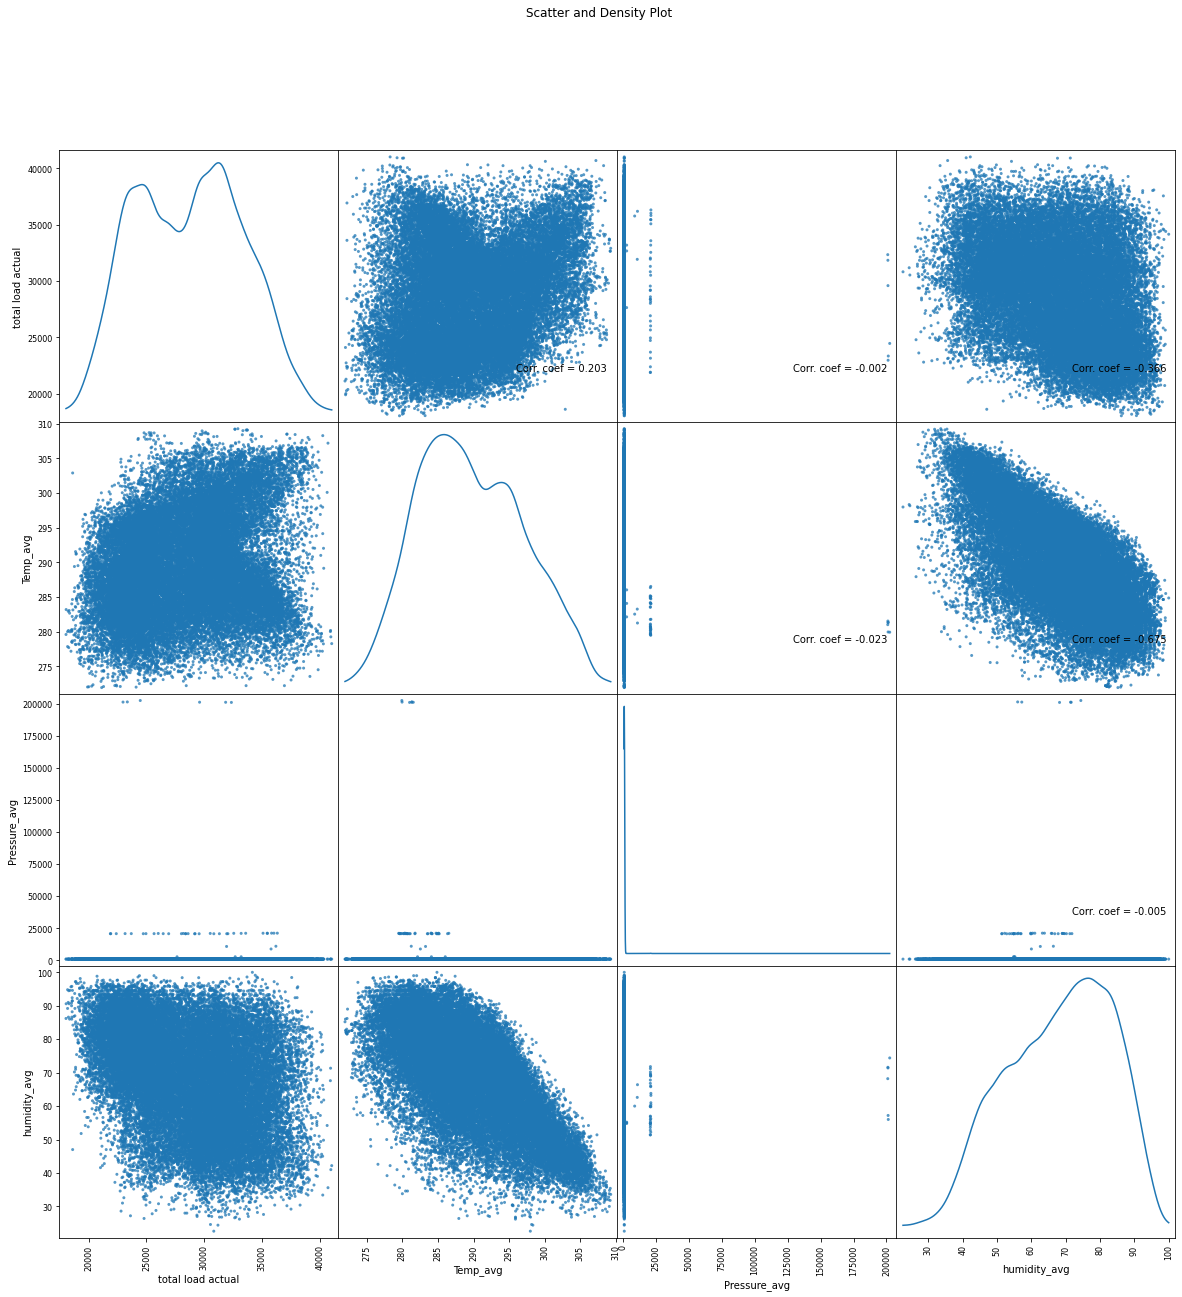

In [15]:

plotScatterMatrix(PandasEnergyWeatherDF, 20, 10)

##Relationship for the Weather Energy Data

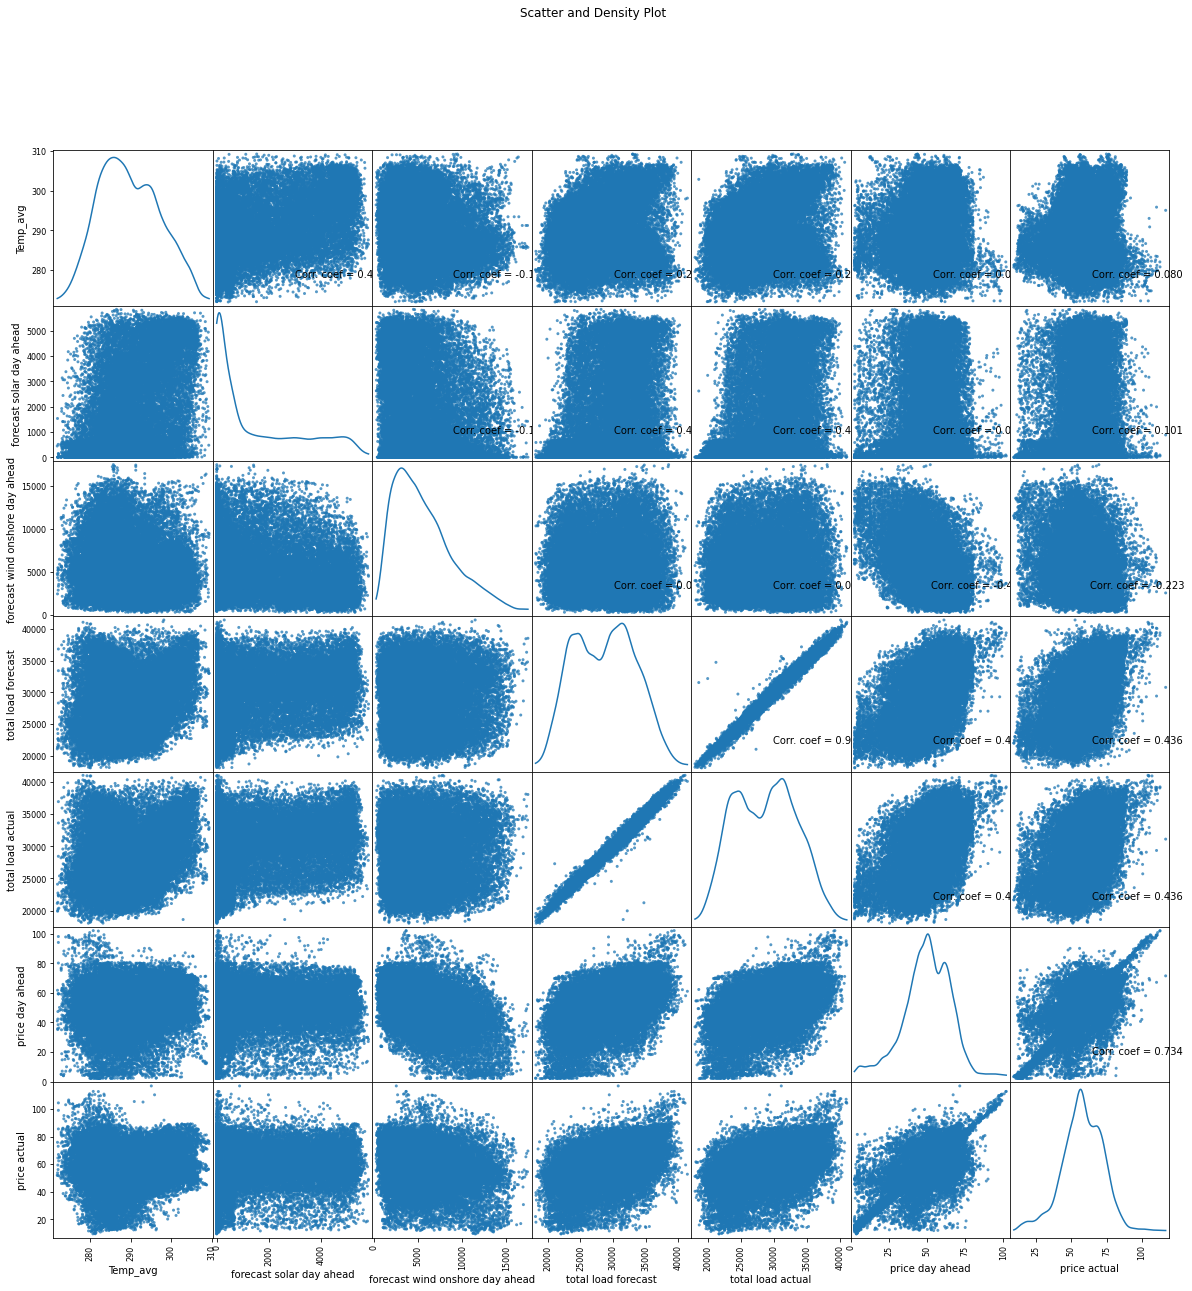

In [16]:
plotScatterMatrix(PandasWeatherEnergyDF, 20, 10)


# View of the Temperature, Total actual Load and the Price over time.

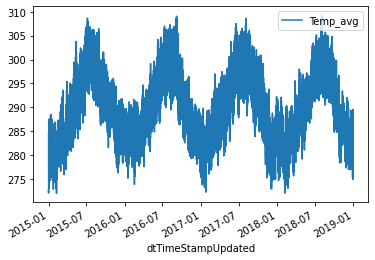

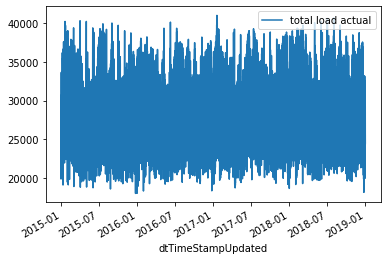

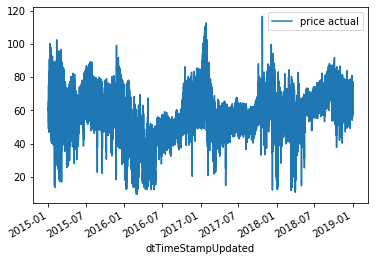

In [17]:


PandasWeatherEnergyDF.plot(x="dtTimeStampUpdated", y=["Temp_avg"])
plt.show()

PandasWeatherEnergyDF.plot(x="dtTimeStampUpdated", y=["total load actual"])
plt.show()

PandasWeatherEnergyDF.plot(x="dtTimeStampUpdated", y=["price actual"])
plt.show()



# Createing a Long Short Term Memory model to try and predict energy load

### Setting up the data and looking at visulaizations for Load, Temp, Presure and Humidity.

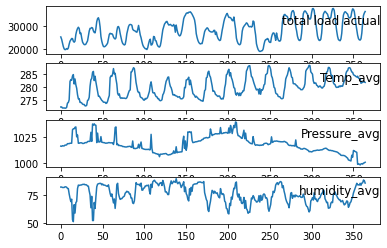

In [18]:
PandasEnergyWeatherDF.set_index('dtTimeStampUpdated', inplace = True)

values = PandasEnergyWeatherDF.values
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:365, group])
	pyplot.title(PandasEnergyWeatherDF.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Spliting the data into test and training sets

In [21]:
# split into train and test sets
#values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(8760, 1, 3) (8760,) (26268, 1, 3) (26268,)


## Desiging and creating the model

Epoch 1/100
122/122 - 4s - loss: 67.0012 - val_loss: 66.2393
Epoch 2/100
122/122 - 1s - loss: 64.8378 - val_loss: 64.0729
Epoch 3/100
122/122 - 1s - loss: 62.6761 - val_loss: 61.9071
Epoch 4/100
122/122 - 1s - loss: 60.5150 - val_loss: 59.7414
Epoch 5/100
122/122 - 1s - loss: 58.3539 - val_loss: 57.5757
Epoch 6/100
122/122 - 1s - loss: 56.1920 - val_loss: 55.4100
Epoch 7/100
122/122 - 1s - loss: 54.0307 - val_loss: 53.2444
Epoch 8/100
122/122 - 1s - loss: 51.8695 - val_loss: 51.0787
Epoch 9/100
122/122 - 1s - loss: 49.7083 - val_loss: 48.9132
Epoch 10/100
122/122 - 1s - loss: 47.5471 - val_loss: 46.7476
Epoch 11/100
122/122 - 1s - loss: 45.3858 - val_loss: 44.5822
Epoch 12/100
122/122 - 1s - loss: 43.2246 - val_loss: 42.4171
Epoch 13/100
122/122 - 1s - loss: 41.0634 - val_loss: 40.2533
Epoch 14/100
122/122 - 1s - loss: 38.9037 - val_loss: 38.0954
Epoch 15/100
122/122 - 1s - loss: 36.7456 - val_loss: 35.9452
Epoch 16/100
122/122 - 1s - loss: 34.5917 - val_loss: 33.8112
Epoch 17/100
122/

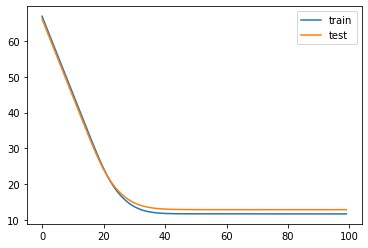

In [22]:
# design network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Checking the results of the Model

In [24]:
from keras.layers import concatenate
from sklearn.metrics import mean_squared_error
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))

# calculate RMSE

print(mean_squared_error(test_y, yhat))

rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

232.48802374826883
Test RMSE: 15.248


## Visualization of the prediction vs actual

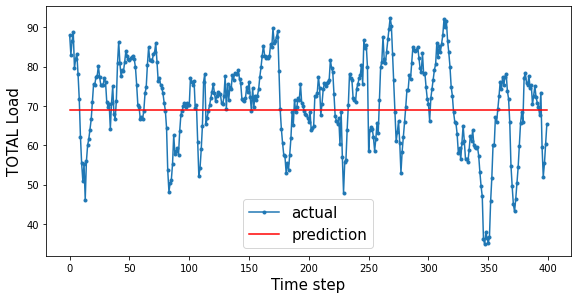

In [26]:
pred = model.predict(test_X)
idx = 400
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, test_y[:idx], marker='.', label="actual")
plt.plot(aa, yhat[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# Creating additional prediction Models
### Setting up the data for the models

In [43]:
df = PandasEnergyWeatherDF.sort_index()
target_column = ['total load actual'] 
predictors = list(set(list(df.columns))-set(target_column))
df[predictors] = df[predictors]/df[predictors].max()
df.describe()

,total load actual,Temp_avg,Pressure_avg,humidity_avg
count,35028.000000,35028.000000,35028.000000,35028.000000
mean,28696.939905,0.936685,0.005286,0.682181
std,4574.987950,0.023479,0.013304,0.148937
min,18041.000000,0.879314,0.004012,0.226000
25%,24807.750000,0.918510,0.005002,0.568000
50%,28901.000000,0.934569,0.005023,0.698000
75%,32192.000000,0.954177,0.005043,0.802000
max,41015.000000,1.000000,1.000000,1.000000


### defining predictors and target
### setting up test and training sets

In [44]:
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(24519, 3)
(10509, 3)


### Ridge Model

In [45]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

4254.827749792242
0.136185478314513
4234.536646970196
0.14060291578775475


### Ridge Results

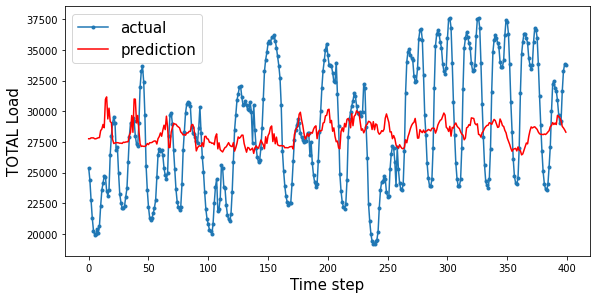

In [46]:
pred = rr.predict(X)
idx = 400
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, y[:idx], marker='.', label="actual")
plt.plot(aa, pred[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Lasso Model

In [47]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

4254.827840653484
0.1361854414212399
4234.541855537697
0.14060080163414113


### Lasso Results

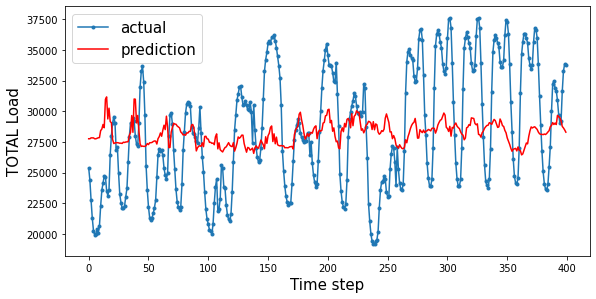

In [48]:
pred = model_lasso.predict(X)
idx = 400
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, y[:idx], marker='.', label="actual")
plt.plot(aa, pred[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Elastic Model

In [49]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

4274.636074490374
0.12812378982508799
4255.736646545202
0.1319763168693785


### Elastic Results

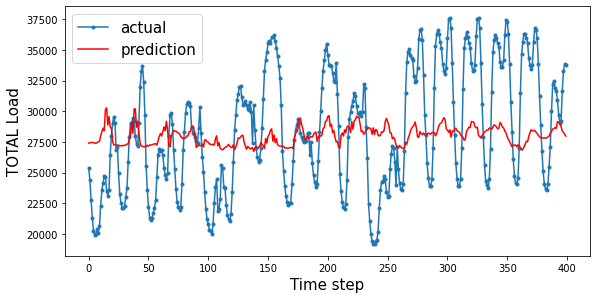

In [50]:

pred = model_enet.predict(X)
idx = 400
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, y[:idx], marker='.', label="actual")
plt.plot(aa, pred[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# Kmeans Clustering

## Creating Dataframe

In [52]:
dfKmeans= df[['total load actual','Temp_avg','humidity_avg','Pressure_avg']]
dfKmeans


,total load actual,Temp_avg,humidity_avg,Pressure_avg
dtTimeStampUpdated,,,,
2015-01-01 01:00:00,25385.0,0.881091,0.824,0.005020
2015-01-01 02:00:00,24382.0,0.881160,0.824,0.005019
2015-01-01 03:00:00,22734.0,0.879822,0.820,0.005022
2015-01-01 04:00:00,21286.0,0.879791,0.820,0.005021
2015-01-01 05:00:00,20264.0,0.879974,0.820,0.005021
...,...,...,...,...
2018-12-31 20:00:00,30653.0,0.919823,0.736,0.005083
2018-12-31 21:00:00,29735.0,0.912787,0.680,0.005087
2018-12-31 22:00:00,28071.0,0.908118,0.714,0.005086


## Creating the model

In [53]:


scaler = StandardScaler()
data_scaled = scaler.fit_transform(dfKmeans)

# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

# inertia on the fitted data
kmeans.inertia_

95425.55825878611

Text(0, 0.5, 'Inertia')

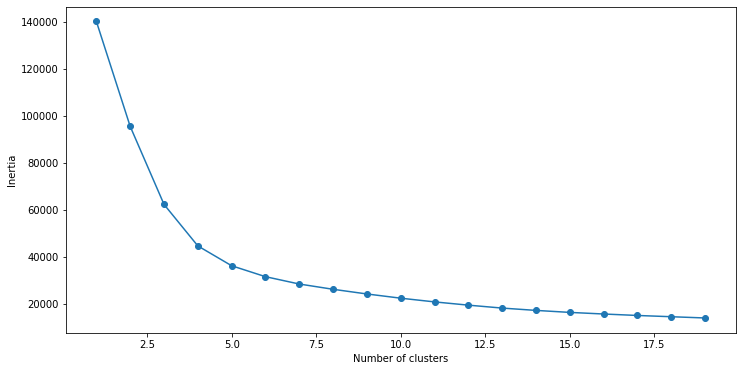

In [54]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## Color dictionary for visualization

In [55]:
color_dict = dict({0:'brown',
                   1:'green',
                   2:'orange',
                   3:'red',
                   4:'dodgerblue',
                   5:'black',
                   6:'blue',
                   7:'pink',
                   8:'purple'})

## Creating 3D plot of Kmeans clusters of 4

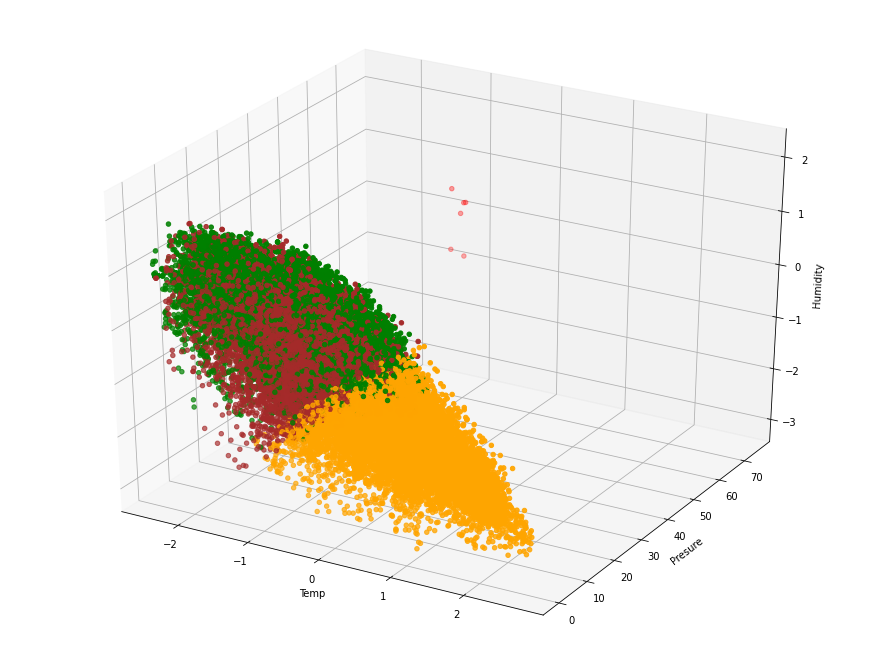

In [65]:

 
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

y = frame.iloc[:,3]
x = frame.iloc[:,1]
z = frame.iloc[:,2]
c = frame['cluster'].map(color_dict)
ax.scatter(x,y,z, c=c, cmap='coolwarm')
ax.set_ylabel('Presure')
ax.set_xlabel('Temp')
ax.set_zlabel('Humidity')

# show plot
plt.show()